# Pixel Level Calibration

There are a lot of existing frameworks for phase retrieval, but it is not necessarily straightforward to simultaneously retrieve:

- aberrations (the optical distortions, maybe tens of parameters)
- astrometry (the positions of stars, tens of parameters)
- inter-pixel sensitivity (aka the 'flat field', on a large pixel grid!)

The dimensionality of the pixel grid can be so high that it is hard to retrieve without automatic differentiation (autodiff). With ∂Lux, it's easy*!

\* This is the topic of a Desdoigts et al. paper in prep. It was _not_ easy to build, and we're pretty happy about it.

In [1]:
# Core jax
import jax
import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.layers as dll
import dLux.utils as dlu

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

Now we need to construct our model. There are three components that we need:

1. Optics: Here we will use the pre-built Toliman optics model from the `dLuxToliman` package, ensuring we add some aberration to recover.

2. Detector: Here we create a simple detector that applies a simple flat field.

3. Sources: This will be a set of point sources with different positions and fluxes. 

Let's put all this together and see how it looks.

In [14]:
from dLuxToliman import TolimanOptics

# Construct optics
coeffs = 2e-8 * jr.normal(jr.PRNGKey(0), (7,))
optics = TolimanOptics(radial_orders=[2, 3], coefficients=coeffs, psf_npixels=128)

# Create Detector
det_npix = optics.psf_npixels * optics.oversample
pix_response = 1 + 0.05*jr.normal(jr.PRNGKey(0), [det_npix, det_npix])
detector = dl.LayeredDetector([dll.ApplyPixelResponse(pix_response)])

# Create Sources
Nstars = 15
true_positions = dlu.arcsec2rad(jr.uniform(jr.PRNGKey(0), (Nstars, 2), minval=-20, maxval=20))
true_fluxes = 1e8 + 1e7*jr.normal(jr.PRNGKey(1), (Nstars,))
wavels = 1e-9 * np.linspace(545, 645, 3)
source = dl.PointSources(wavels, true_positions, true_fluxes)
# source = dl.PointSource(wavelengths=wavels)

Now we need to introduce the dithers. We can utilise the built-in `Dither` observation class:

In [15]:
# Observation strategy, define dithers
det_pixsize = dlu.arcsec2rad(optics.psf_pixel_scale / optics.oversample)
# det_pixsize = dlu.arcsec2rad(optics.psf_pixel_scale)
dithers = det_pixsize * np.array([[0, 0], [+1, +1], [+1, -1], [-1, +1], [-1, -1]]) / 5
# observation = dl.Dither(dithers)

In [16]:
# Combine into instrument and observe!
# tel = dl.Instrument(optics, source, detector)
tel = dl.Dither(dithers, optics, source, detector)
psfs = tel.model()

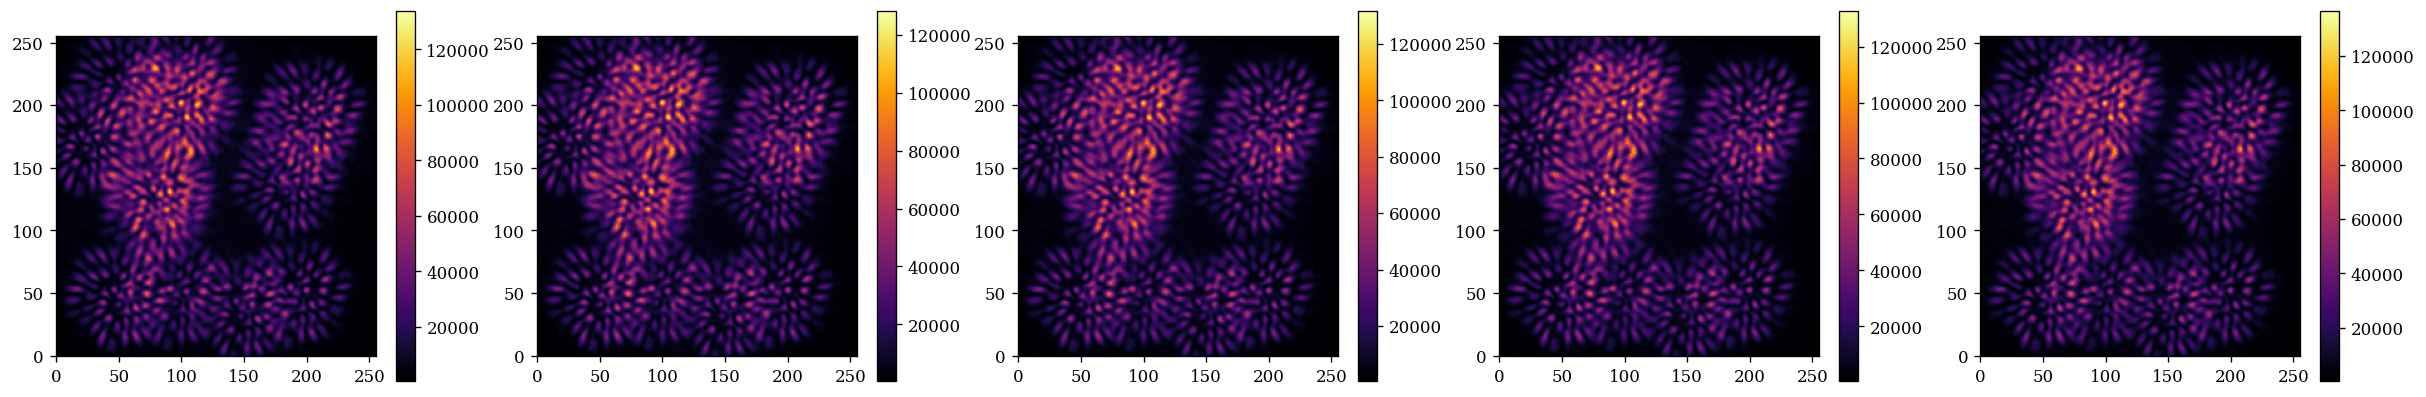

In [17]:
# Apply some noise to the PSF Background noise
data = jr.poisson(jr.PRNGKey(0), psfs)

plt.figure(figsize=(25, 4))
for i in range(len(psfs)):
    plt.subplot(1, 5, i+1)
    plt.imshow(data[i])
    plt.colorbar()
plt.show()

There are four sets of parameters we are going to learn:
 - Positions
 - Fluxes
 - Zernike aberrations
 - Pixel responses
 
We start by defining the paths to those parameters; we will define them individually so that we can refer to them easily later.

In [18]:
positions = 'source.position'
fluxes    = 'source.flux'
zernikes  = 'aperture.coefficients'
flatfield = 'ApplyPixelResponse.pixel_response'

parameters = [positions, fluxes, zernikes, flatfield]

Each of these parameters needs a different initialisation:
 - Positions need to be shifted by some random value
 - Fluxes need to be multiplied by some random value
 - Zernike coefficients need to be set to zero
 - Pixel response values need to be set to one
 
We perturb the values to initialise the model.

In [19]:
# Add small random values to the positions
model = tel.add(positions, 2.*det_pixsize*jr.normal(jr.PRNGKey(0),  (Nstars, 2)))

# Multiply the fluxes by small random values
model = model.multiply(fluxes, 1 + 0.1*jr.normal(jr.PRNGKey(0), (Nstars,)))

# Set the zernike coefficients to zero
model = model.set(zernikes, np.zeros(model.get(zernikes).shape))

# Set the flat field to uniform
model = model.set(flatfield, np.ones((det_npix, det_npix)))

# Generate psfs
psfs = model.model()

We can see the residuals are not optimal:

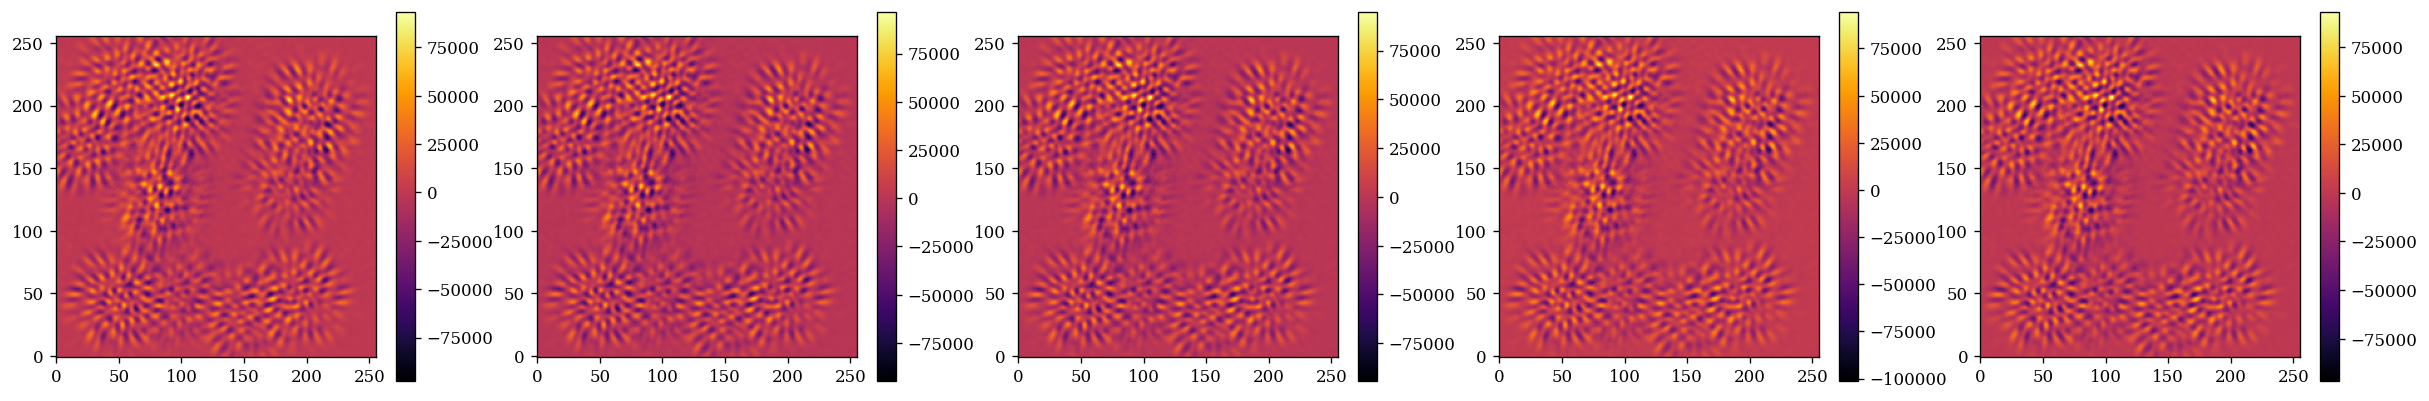

In [20]:
plt.figure(figsize=(25, 4))
for i in range(len(psfs)):
    plt.subplot(1, 5, i+1)
    plt.imshow(psfs[i] - data[i])
    plt.colorbar()
plt.show()

Now we want to generate an `optax` optimiser object that we can use to train each parameter individually. Because of the various scales and effects on the loss function that each parameter has, we need to set individual learning rates and optimisation schedules for every parameter. Luckily, we have built some functions to help specifically with that!

In [21]:
# So first we simply set the simple parameters to use an adam optimiser 
# algorithm, with individual learning rates
pos_optimiser   = optax.adam(1e-7)
flux_optimiser  = optax.adam(1e6)
coeff_optimiser = optax.adam(2e-9)

# Now the flat-field, because it is highly covariant with the mean flux level
# we don't start learning its parameters until the 100th epoch.
FF_sched = optax.piecewise_constant_schedule(init_value=1e-2*1e-8, 
                             boundaries_and_scales={100 : int(1e8)})
FF_optimiser = optax.adam(FF_sched)

# Combine the optimisers into a list
optimisers = [pos_optimiser, flux_optimiser, coeff_optimiser, FF_optimiser]

# Generate out optax optimiser, and also get our args
optim, opt_state = zdx.get_optimiser(model, parameters, optimisers)

Poisson log-likelihood:

In [22]:
@zdx.filter_jit
@zdx.filter_value_and_grad(parameters)
def loss_fn(model, data):
    out = model.model()
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

Call once to jit compile:

In [23]:
%%time
loss, grads = loss_fn(model, data) # Compile
print("Initial Loss: {}".format(int(loss)))

Initial Loss: 1296900864
CPU times: user 3.65 s, sys: 124 ms, total: 3.77 s
Wall time: 905 ms


Run gradient descent:

In [24]:
losses, models_out = [], []
with tqdm(range(200),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model, data)    
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)
        losses.append(loss)
        models_out.append(model)
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Format the output into arrays:

In [25]:
nepochs = len(models_out)
psfs_out = models_out[-1].model()

positions_found  = np.array([model.get(positions) for model in models_out])
fluxes_found     = np.array([model.get(fluxes)    for model in models_out])
zernikes_found   = np.array([model.get(zernikes)  for model in models_out])
flatfields_found = np.array([model.get(flatfield) for model in models_out])

Pull out the quantities to be plotted (e.g. final model and residuals):

In [26]:
coeff_residuals = coeffs - zernikes_found
flux_residuals = true_fluxes - fluxes_found

scaler = 1e3
positions_residuals = true_positions - positions_found
r_residuals_rads = np.hypot(positions_residuals[:, :, 0], positions_residuals[:, :, 1])
r_residuals = dlu.rad2arcsec(r_residuals_rads)

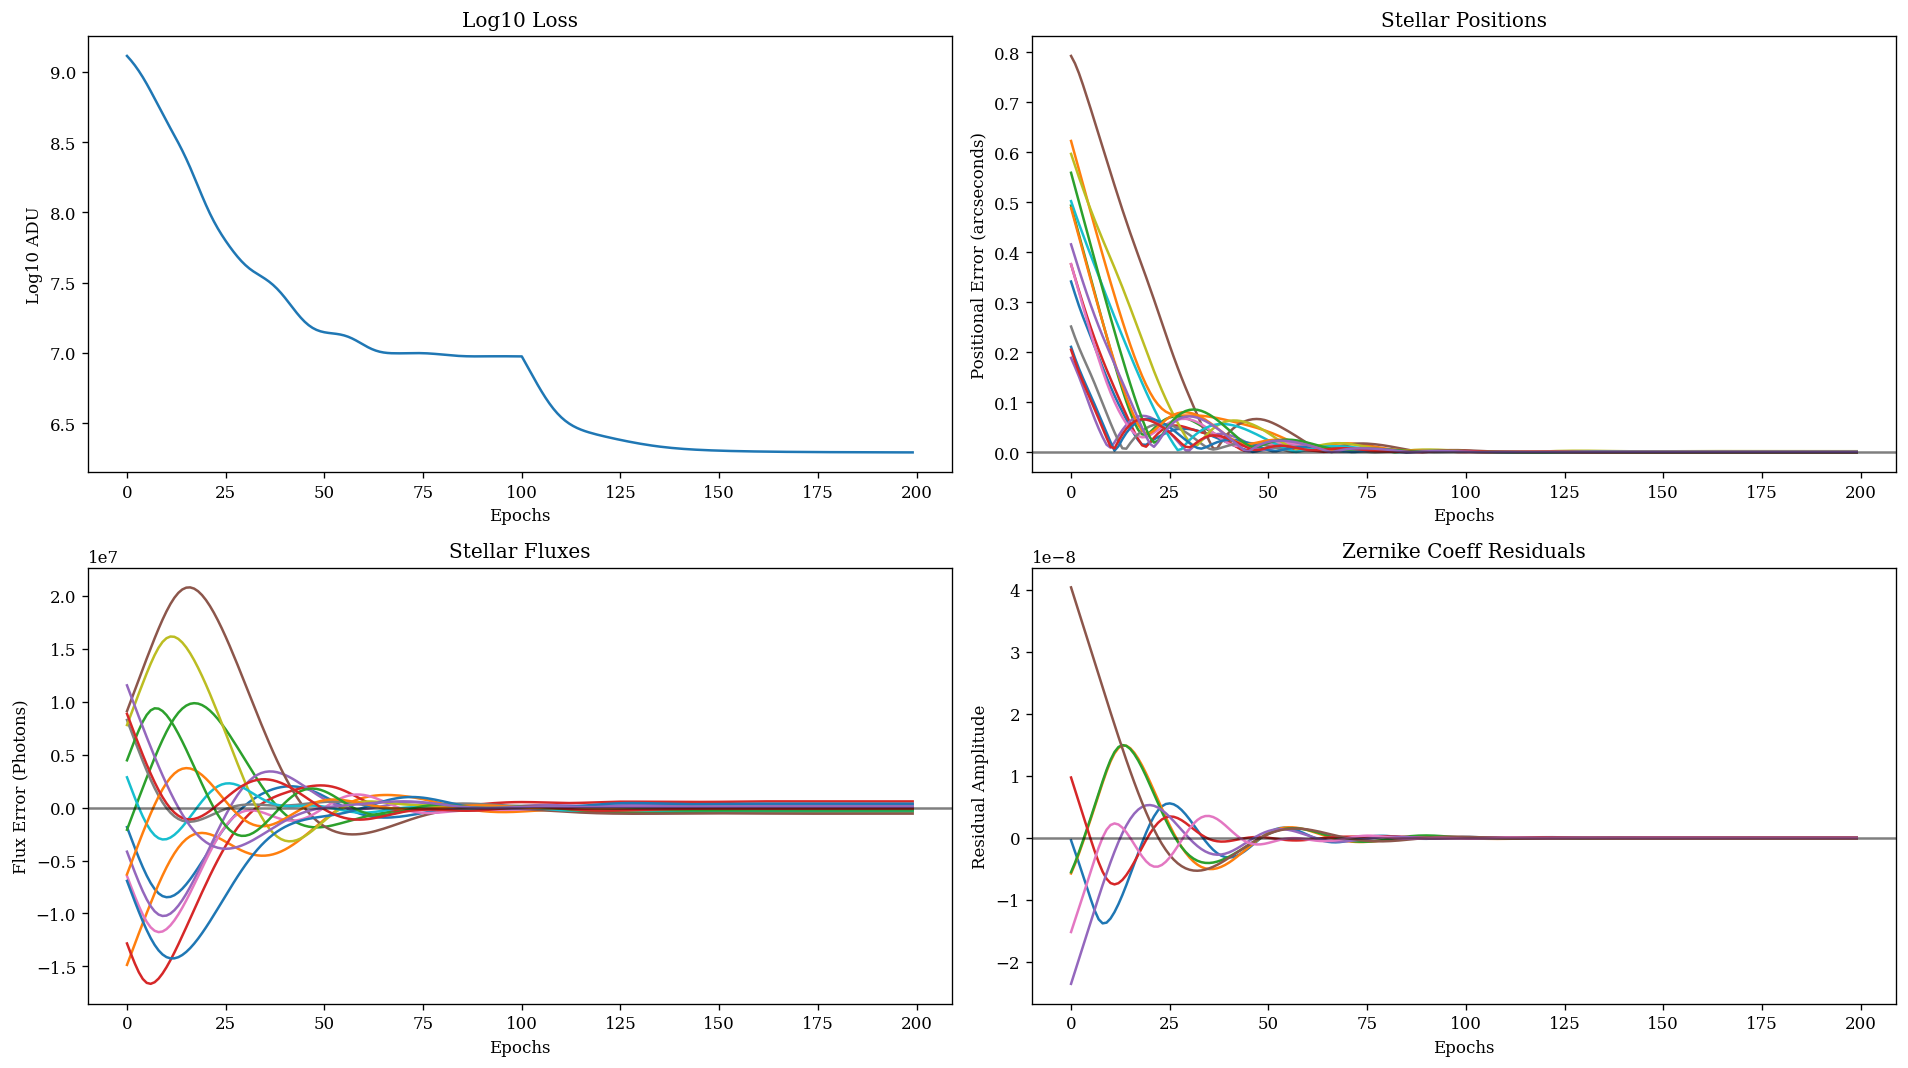

In [27]:
j = len(models_out)
plt.figure(figsize=(16, 13))

plt.subplot(3, 2, 1)
plt.title("Log10 Loss")
plt.xlabel("Epochs")
plt.ylabel("Log10 ADU")
plt.plot(np.log10(np.array(losses)[:j]))

plt.subplot(3, 2, 2)
plt.title("Stellar Positions")
plt.xlabel("Epochs")
plt.ylabel("Positional Error (arcseconds)")
plt.plot(r_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 3)
plt.title("Stellar Fluxes")
plt.xlabel("Epochs")
plt.ylabel("Flux Error (Photons)")
plt.plot(flux_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 4)
plt.title("Zernike Coeff Residuals")
plt.xlabel("Epochs")
plt.ylabel("Residual Amplitude")
plt.plot(coeff_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.tight_layout()
plt.show()

How did the phase retrieval go? Really well, as it happens!

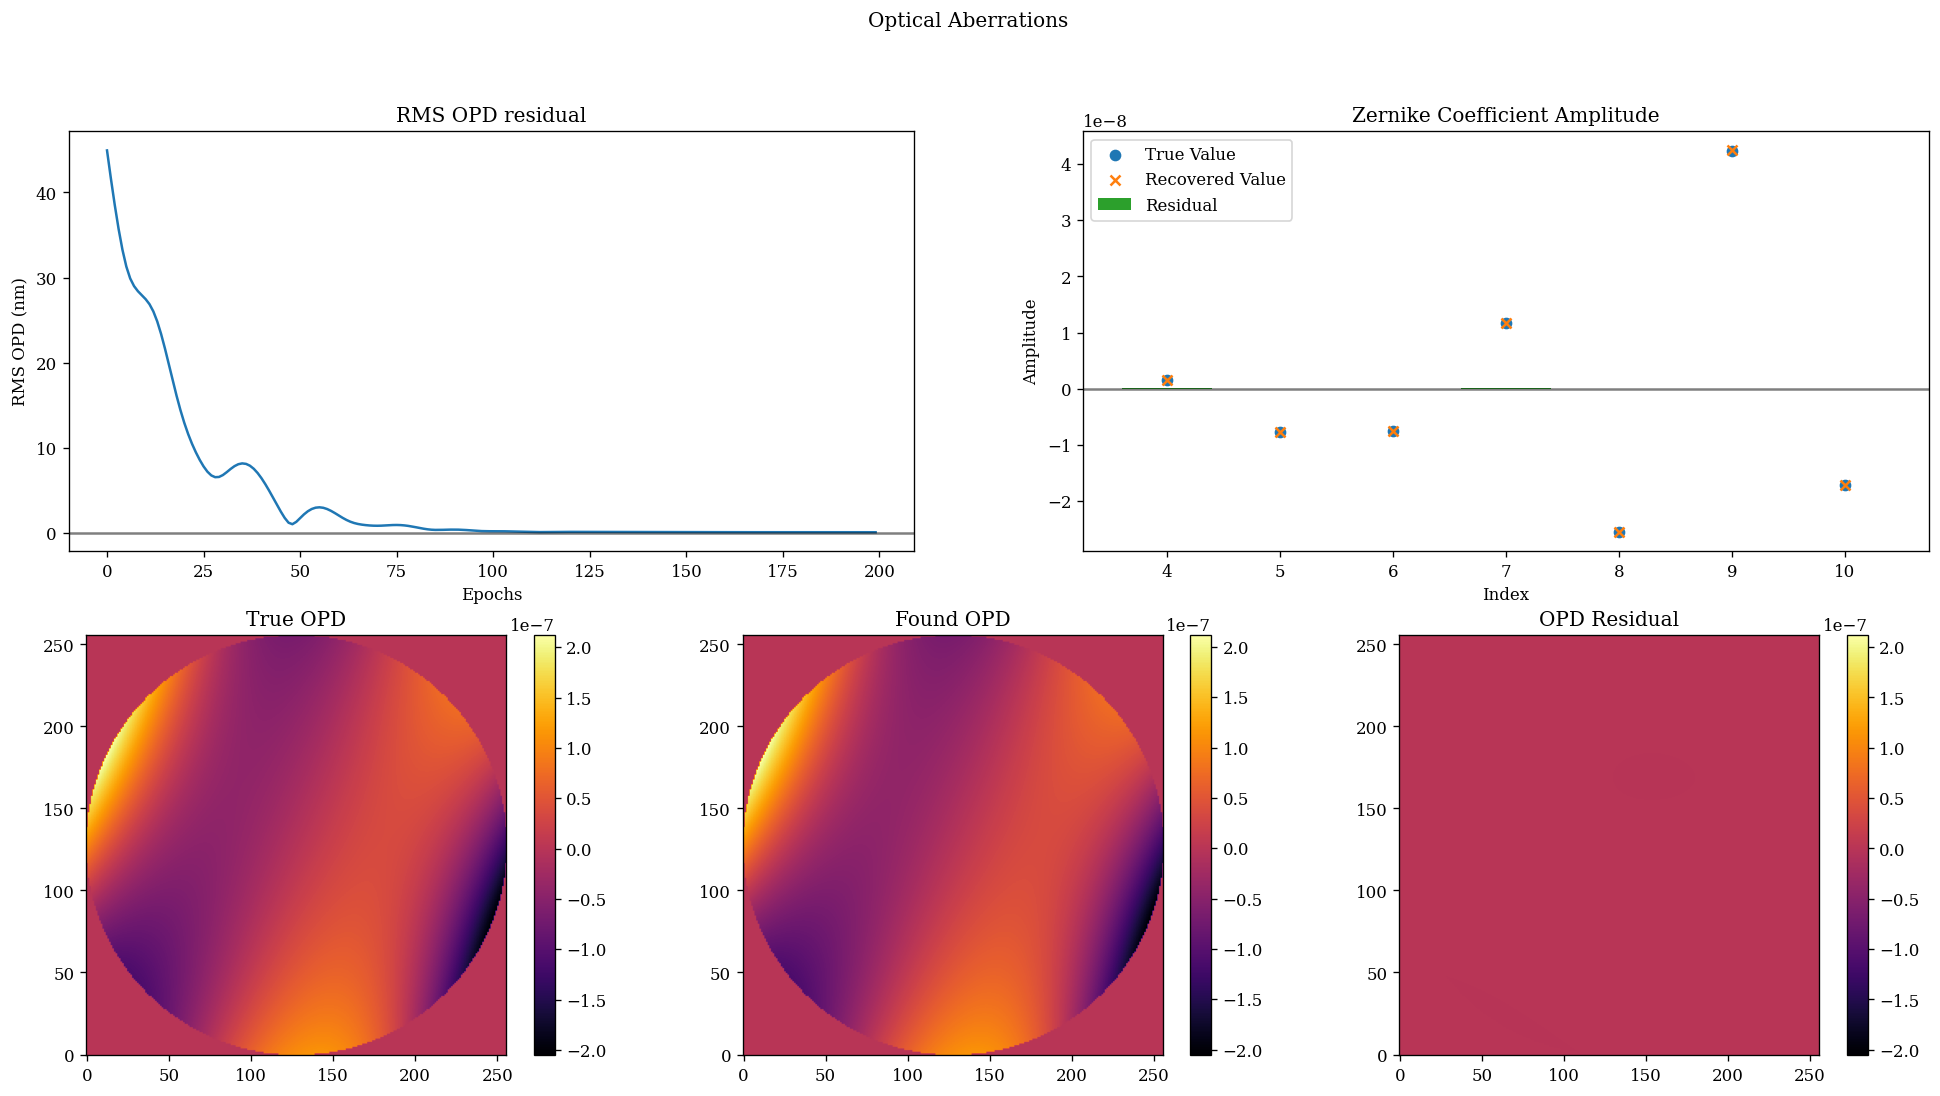

In [31]:
# OPDs
true_opd = tel.aperture.eval_basis()
opds_found = np.array([model.aperture.eval_basis() for model in models_out])
found_opd = opds_found[-1]
opd_residuls = true_opd - opds_found
opd_rmse_nm = 1e9*np.mean(opd_residuls**2, axis=(-1,-2))**0.5

vmin = np.min(np.array([true_opd, found_opd]))
vmax = np.max(np.array([true_opd, found_opd]))

# Coefficients
true_coeff = tel.get(zernikes)
found_coeff = models_out[-1].get(zernikes)
index = np.arange(len(true_coeff))+4

plt.figure(figsize=(20, 10))
plt.suptitle("Optical Aberrations")

plt.subplot(2, 2, 1)
plt.title("RMS OPD residual")
plt.xlabel("Epochs")
plt.ylabel("RMS OPD (nm)")
plt.plot(opd_rmse_nm)
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(2, 2, 2)
plt.title("Zernike Coefficient Amplitude")
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.scatter(index, true_coeff, label="True Value")
plt.scatter(index, found_coeff, label="Recovered Value", marker='x')
plt.bar(index, true_coeff - found_coeff, label='Residual')
plt.axhline(0, c='k', alpha=0.5)
plt.legend()

plt.subplot(2, 3, 4)
plt.title("True OPD")
plt.imshow(true_opd)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.title("Found OPD")
plt.imshow(found_opd)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.title("OPD Residual")
plt.imshow(true_opd - found_opd, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

Most impressively, we are recovering the thousands of flat field parameters pretty well too!

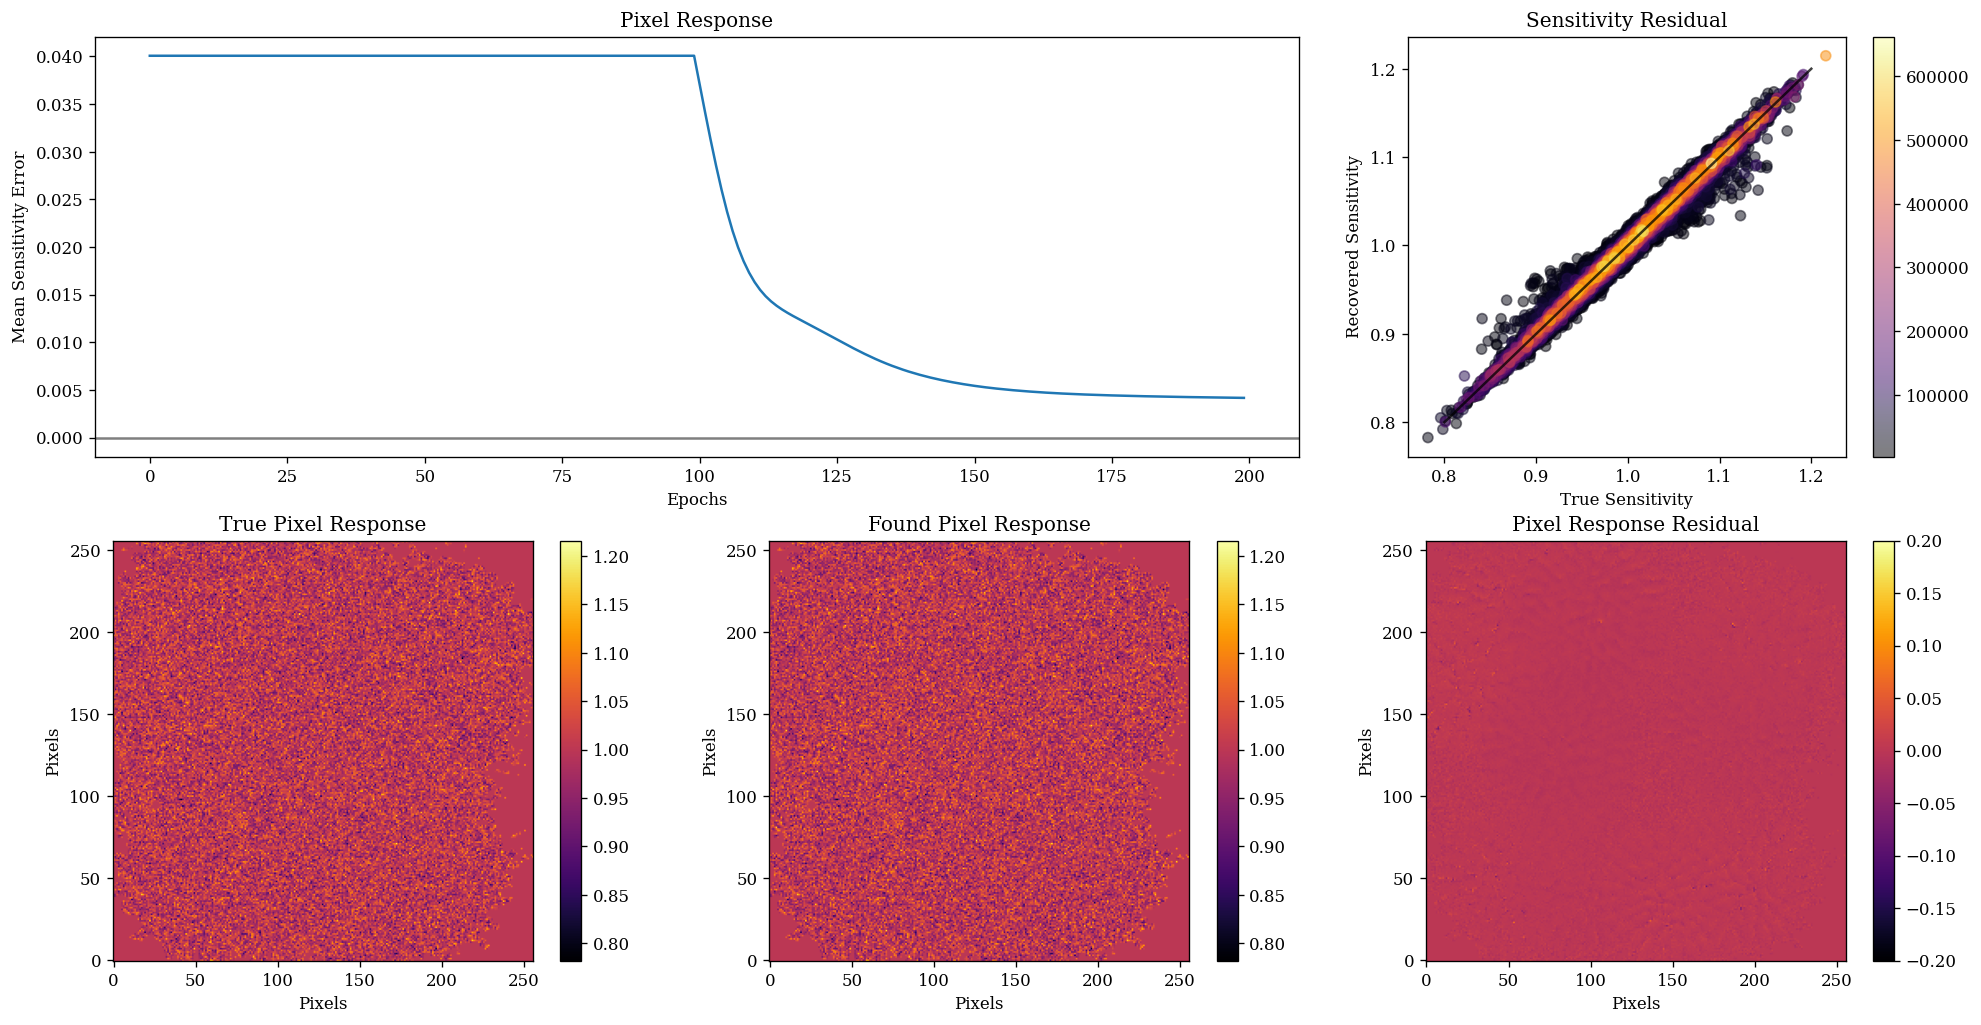

In [32]:
# calculate the mask where there was enough flux to infer the flat field
thresh = 2500
fmask = data.mean(0) >= thresh

out_mask = np.where(data.mean(0) < thresh)
in_mask = np.where(data.mean(0) >= thresh)

data_tile = np.tile(data.mean(0), [len(models_out), 1, 1])
in_mask_tiled = np.where(data_tile >= thresh)

# calculate residuals
pr_residuals = pix_response[in_mask] - flatfields_found[-1][in_mask]

# for correlation plot
true_pr_masked = pix_response.at[out_mask].set(1)
found_pr_masked = flatfields_found[-1].at[out_mask].set(1)

# FF Scatter Plot
data_sum = data.sum(0) # [flux_mask]
colours = data_sum.flatten()
ind = np.argsort(colours)
colours = colours[ind]

pr_true_flat = true_pr_masked.flatten()
pr_found_flat = found_pr_masked.flatten()

pr_true_sort = pr_true_flat[ind]
pr_found_sort = pr_found_flat[ind]

# Errors
pfound = flatfields_found[in_mask_tiled].reshape([len(models_out), len(in_mask[0])])
ptrue = pix_response[in_mask]
pr_res = ptrue - pfound
masked_error = np.abs(pr_res).mean(-1)

plt.figure(figsize=(20, 10))
plt.subplot(2, 3, (1,2))
plt.title("Pixel Response")
plt.xlabel("Epochs")
plt.ylabel("Mean Sensitivity Error")
plt.plot(masked_error)
plt.axhline(0, c='k', alpha=0.5)

# FF Scatter Plot
data_sum = data.sum(0)
colours = data_sum.flatten()
ind = np.argsort(colours)
colours = colours[ind]

pr_true_flat = true_pr_masked.flatten()
pr_found_flat = found_pr_masked.flatten()

pr_true_sort = pr_true_flat[ind]
pr_found_sort = pr_found_flat[ind]

plt.subplot(2, 3, 3)
plt.plot(np.linspace(0.8, 1.2), np.linspace(0.8, 1.2), c='k', alpha=0.75)
plt.scatter(pr_true_sort, pr_found_sort, c=colours, alpha=0.5)
plt.colorbar()
plt.title("Sensitivity Residual")
plt.ylabel("Recovered Sensitivity")
plt.xlabel("True Sensitivity")

plt.subplot(2, 3, 4)
plt.title("True Pixel Response")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(true_pr_masked)
plt.colorbar()

vmin = np.min(pix_response)
vmax = np.max(pix_response)

plt.subplot(2, 3, 5)
plt.title("Found Pixel Response")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(found_pr_masked, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.title("Pixel Response Residual")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(true_pr_masked - found_pr_masked, vmin=-0.2, vmax=0.2)
plt.colorbar()

plt.show()